In [1]:
from css_utility import *
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import norm
import itertools
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline

In [20]:
def evalPre_by_folder(path,target='all',colormap="Set1"):
    """
    path: the directory you have the pretrain result (eval_results.txt)
          Multiple files can be processed.
    target: if designated as "all", it considers all the files. 
            Otherwise, a list containing the numbers of the file you want to analyze should be given.
    """
    file_list=[os.path.join(path, file) for file in sorted(os.listdir(path))]
    print("\n".join(file_list))
    
    file_df_all=[]
    if target=='all':        
        for i, file in enumerate(file_list):
            f_name=re.search(r'eval_results_(.*).txt', file).group(1)
            file_df=pd.read_csv(file, header=None, names=["perplexity"])
            file_df_all.append(file_df)
        result_df = pd.concat(file_df_all)
        
    elif type(target)==list and type(target[0])==int:
        for i in enumerate(target):
            f_name=re.search(r'eval_results_(.*).txt', file).group(1)
            file_df=pd.read_csv(file_list[i], header=None, names=["perplexity"])
            file_df_all.append(file_df)
        result_df = pd.concat(file_df_all)
    
#     fig=plt.figure(figsize=(6,4))
#     p=sns.lineplot(data=df_concat, palette=colormap)
    
    return result_df
    

In [21]:
result_df=evalPre_by_folder("../database/pretrain/test_telo_v1/complexity/")

../database/pretrain/test_telo_v1/complexity/eval_results_Comp4mer.txt
../database/pretrain/test_telo_v1/complexity/eval_results_Comp5mer.txt
../database/pretrain/test_telo_v1/complexity/eval_results_Less4mer.txt
../database/pretrain/test_telo_v1/complexity/eval_results_Less5mer.txt


In [22]:
result_df

,perplexity
0,5.959226
1,2.662241
2,2.019468
3,1.753737
4,1.650974
...,...
16,1.140483
17,1.141680
18,1.139820
19,1.140323


In [13]:
re.search(r'eval_results_(.*).txt', test_list[0]).group(1)

'Comp4mer'

In [3]:
def evalDFconcat(df_lst, col_name, col_rename, colormap="Set1"):
    """
    Input
    (1) df_lst: a list of target dataframes
    (2) col_name: the columns of interest
    (3) col_rename: a list of columns for the concatenated dataframes
    """
    assert type(df_lst), "Input should be a list of dataframes"
    assert type(col_rename), "col_rename should be a list"
    assert len(df_lst)==len(col_rename), "Check the length of input list"
    assert col_name in df_lst[0].columns, "'{}' is not in the column list of dataframe".format(col_name)
    df_col_lst=[]
    for num in range(len(df_lst)):       
        df_col_lst.append(df_lst[num][col_name])
    df_concat=pd.concat(df_col_lst, axis=1)
    df_concat.columns=col_rename
    
    fig=plt.figure(figsize=(6,4))
    p=sns.lineplot(data=df_concat, palette=colormap)
    p.set_ylabel(col_name, fontsize=14)
    p.set_xlabel("Iteration", fontsize=14)
#     p.set_ylim(1.0,2.8)
    p.legend(fontsize=14)
    
    return df_concat

In [254]:
# pretrain with 5mer result (eval_results.txt)
path="../database/pretrain/test_telo_v1/"

In [257]:
file_list=[os.path.join(path, file) for file in sorted(os.listdir(path))]

In [258]:
file_list

['../database/pretrain/test_telo_v1/eval_results_allchr_4mer_v1_01_b5_2.txt',
 '../database/pretrain/test_telo_v1/eval_results_allchr_5mer_v1_01_b10_6.txt',
 '../database/pretrain/test_telo_v1/eval_results_allchr_5mer_v1_01_b2_1.txt',
 '../database/pretrain/test_telo_v1/eval_results_allchr_5mer_v1_01_b5_2.txt',
 '../database/pretrain/test_telo_v1/eval_results_allchr_5mer_v1_01_b8_4.txt',
 '../database/pretrain/test_telo_v1/eval_results_chr1_3mer_v1_01.txt',
 '../database/pretrain/test_telo_v1/eval_results_chr1_4mer_v1_01.txt']

In [259]:
pre_4mer_all_b5_2=pd.read_csv(file_list[0], header=None, names=["perplexity"])
pre_5mer_all_b10_6=pd.read_csv(file_list[1], header=None, names=["perplexity"])
pre_5mer_all_b2_1=pd.read_csv(file_list[2], header=None, names=["perplexity"])
pre_5mer_all_b5_2=pd.read_csv(file_list[3], header=None, names=["perplexity"])
pre_5mer_all_b8_4=pd.read_csv(file_list[4], header=None, names=["perplexity"])
pre_3mer_ch1_b5_2=pd.read_csv(file_list[5], header=None, names=["perplexity"])
pre_4mer_ch1_b5_2=pd.read_csv(file_list[6], header=None, names=["perplexity"])

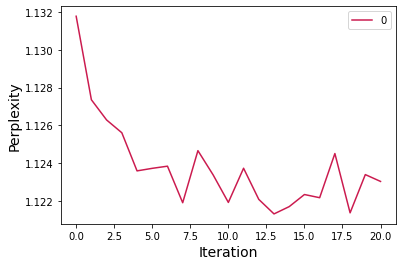

In [260]:
p=plt.figure(figsize=(6,4))
p=sns.lineplot(data=pre_5mer_b5_2, palette="rocket")
p.set_xlabel("Iteration", fontsize=14)
p.set_ylabel("Perplexity", fontsize=14)
plt.show()

In [261]:
df_pre_all=[pre_3mer_ch1_b5_2,pre_4mer_ch1_b5_2,pre_4mer_all_b5_2,pre_5mer_all_b2_1,pre_5mer_all_b5_2]

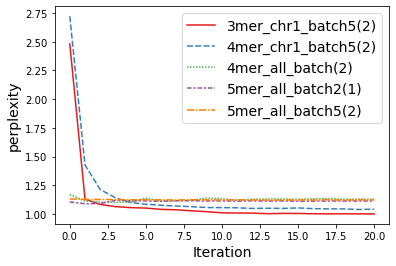

In [262]:
df_concat=evalDFconcat(df_pre_all, "perplexity",["3mer_chr1_batch5(2)", "4mer_chr1_batch5(2)", 
                                                 "4mer_all_batch(2)", "5mer_all_batch2(1)","5mer_all_batch5(2)"])

In [263]:
df_pre_4=[pre_4mer_ch1_b5_2,pre_4mer_all_b5_2]

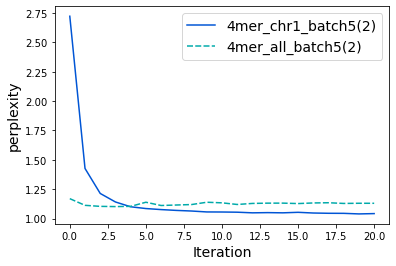

In [264]:
df_concat4=evalDFconcat(df_pre_4,"perplexity",["4mer_chr1_batch5(2)","4mer_all_batch5(2)"],"winter")

In [265]:
df_pre_45=[pre_4mer_all_b5_2,pre_5mer_all_b5_2]

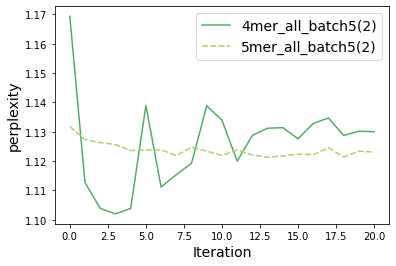

In [266]:
df_concat45=evalDFconcat(df_pre_45,"perplexity",["4mer_all_batch5(2)","5mer_all_batch5(2)"],"summer")

In [267]:
df_pre_34=[pre_3mer_ch1_b5_2,pre_4mer_ch1_b5_2,pre_4mer_all_b5_2]

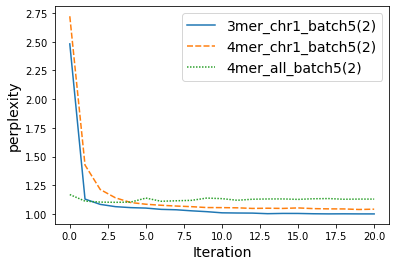

In [268]:
df_concat34=evalDFconcat(df_pre_34,"perplexity",["3mer_chr1_batch5(2)", "4mer_chr1_batch5(2)","4mer_all_batch5(2)"],"tab10")

In [272]:
df_pre_5=[pre_5mer_all_b2_1,pre_5mer_all_b5_2,pre_5mer_all_b8_4,pre_5mer_all_b10_6]

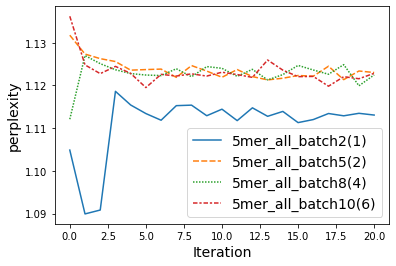

In [274]:
df_concat5=evalDFconcat(df_pre_5,"perplexity",["5mer_all_batch2(1)","5mer_all_batch5(2)",
                                               "5mer_all_batch8(4)","5mer_all_batch10(6)"],
                        "tab10")

In [275]:
pred_path="../database/ft_result/pred/"

In [276]:
pred_maxlen_300=np.load(pred_path+"4/pred_results_maxlen_300.npy") # maxlen 300 (pred maxlen also 300)

In [277]:
pred_maxlen_300_df=pd.DataFrame(pred_maxlen_300)

In [11]:
dev_path_4="../database/fine_tune/genic_and_intergenic/4mer/dev.tsv"

In [12]:
dev_4=pd.read_csv(dev_path_4, sep="\t")

In [13]:
dev_4.head()

,sequence,label
0,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,1
1,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
2,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
3,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
4,EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE E...,1


In [15]:
dev_4.tail()

,sequence,label
995,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
996,NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN N...,0
997,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
998,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
999,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0


In [279]:
dir_path="../database/ft_result/eval/"

In [280]:
def loc_file(dir_path="../database/ft_result/eval/", k=4, add_str="ori"):
    assert type(add_str)==str, "Enter a string!"
    file_path=dir_path+str(k)+"/"+"eval_results_"+add_str+".txt"
    return file_path

In [281]:
def eval2df(file_path):
    eval_df=pd.read_csv(file_path, header=None, index_col=False, \
                        names=["k","acc","auc","f1","mcc","precision","recall"], sep="\s", engine="python")
    return eval_df

In [282]:
eval3_ori_path=loc_file(dir_path,3,"ori")
eval3_200_path=loc_file(dir_path,3,"maxlen_200")
eval4_ori_path=loc_file(dir_path,4,"ori")
eval4_200_path=loc_file(dir_path,4,"maxlen_200")
eval4_300_path=loc_file(dir_path,4,"maxlen_300")
eval4_ep10_path=loc_file(dir_path,4,"epoch10")
eval4_300_ep10_path=loc_file(dir_path,4,"maxlen_300_epoch10")
eval5_300_b10_6_path=loc_file(dir_path,5,"maxlen_300_b10_6")

In [286]:
eval3_ori_df=eval2df(eval3_ori_path)
eval3_200_df=eval2df(eval3_200_path)
eval4_ori_df=eval2df(eval4_ori_path)
eval4_200_df=eval2df(eval4_200_path)
eval4_300_df=eval2df(eval4_300_path)
eval4_ep10_df=eval2df(eval4_ep10_path)
eval4_300_ep10_df=eval2df(eval4_300_ep10_path)
eval5_300_b10_6_df=eval2df(eval5_300_b10_6_path)

In [310]:
def evalDFconcat(df_lst, col_name, col_rename, colormap="Set1"):
    """
    Input
    (1) df_lst: a list of target dataframes
    (2) col_name: the columns of interest
    (3) col_rename: a list of columns for the concatenated dataframes
    """
    assert type(df_lst), "Input should be a list of dataframes"
    assert type(col_rename), "col_rename should be a list"
    assert len(df_lst)==len(col_rename), "Check the length of input list"
    assert col_name in df_lst[0].columns, "'{}' is not in the column list of dataframe".format(col_name)
    df_col_lst=[]
    for num in range(len(df_lst)):       
        df_col_lst.append(df_lst[num][col_name])
    df_concat=pd.concat(df_col_lst, axis=1)
    df_concat.columns=col_rename
    
    fig=plt.figure(figsize=(6,4))
    p=sns.lineplot(data=df_concat, palette=colormap)
    p.set_ylabel(col_name, fontsize=14)
    p.set_xlabel("Iteration", fontsize=14)
    p.legend(fontsize=14)
    
    return df_concat
    

In [311]:
df_lst45=[eval4_ep10_df, eval4_300_ep10_df,eval5_300_b10_6_df]

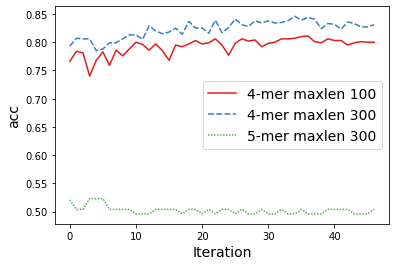

In [312]:
df_concat45=evalDFconcat(df_lst45,"acc",["4-mer maxlen 100", "4-mer maxlen 300", "5-mer maxlen 300"])

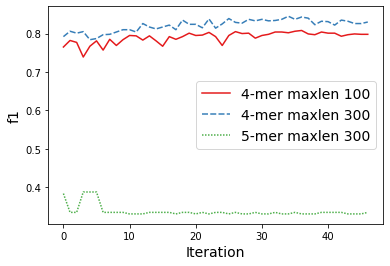

In [313]:
df_concat45=evalDFconcat(df_lst45,"f1",["4-mer maxlen 100", "4-mer maxlen 300", "5-mer maxlen 300"])

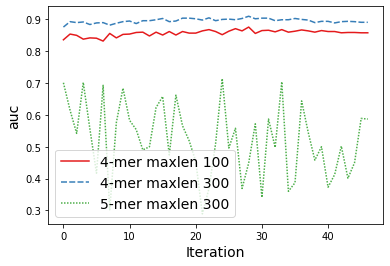

In [324]:
df_concat45=evalDFconcat(df_lst45,"auc",["4-mer maxlen 100", "4-mer maxlen 300", "5-mer maxlen 300"])

In [118]:
df_lst=[eval4_ori_df,eval4_300_df,eval4_ep10_df, eval4_300_ep10_df]

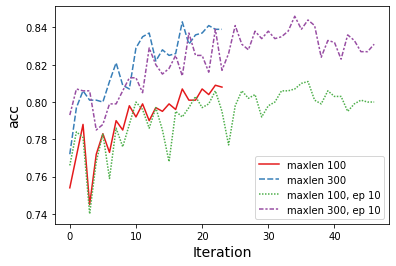

In [120]:
df_concat=evalDFconcat(df_lst,"acc",["maxlen 100","maxlen 300","maxlen 100, ep 10","maxlen 300, ep 10"])

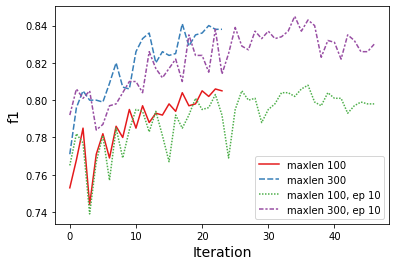

In [126]:
df_concat=evalDFconcat(df_lst,"f1",["maxlen 100","maxlen 300","maxlen 100, ep 10","maxlen 300, ep 10"])

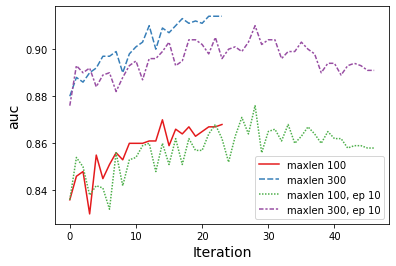

In [128]:
df_concat=evalDFconcat(df_lst,"auc",["maxlen 100","maxlen 300","maxlen 100, ep 10","maxlen 300, ep 10"])

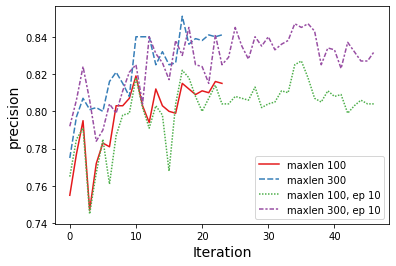

In [129]:
df_concat=evalDFconcat(df_lst,"precision",["maxlen 100","maxlen 300","maxlen 100, ep 10","maxlen 300, ep 10"])

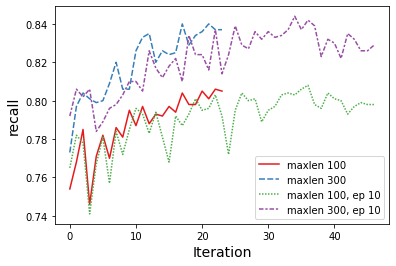

In [130]:
df_concat=evalDFconcat(df_lst,"recall",["maxlen 100","maxlen 300","maxlen 100, ep 10","maxlen 300, ep 10"])

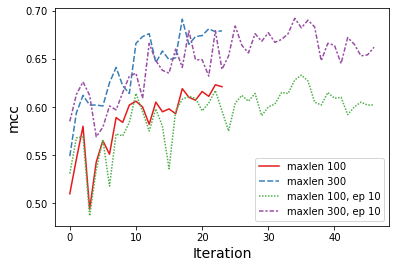

In [131]:
df_concat=evalDFconcat(df_lst,"mcc",["maxlen 100","maxlen 300","maxlen 100, ep 10","maxlen 300, ep 10"])

In [117]:
eval34_acc=pd.concat([eval3_ori_df["acc"],eval3_200_df["acc"],eval4_ori_df["acc"],eval4_200_df["acc"]],\
                    axis=1)
eval34_acc.columns=["3mer: 100","3mer: 200","4mer: 100","4mer: 200"]
eval34_auc=pd.concat([eval3_ori_df["auc"],eval3_200_df["auc"],eval4_ori_df["auc"],eval4_200_df["auc"]],\
                    axis=1)
eval34_auc.columns=["3mer: 100","3mer: 200","4mer: 100","4mer: 200"]
eval34_f1=pd.concat([eval3_ori_df["f1"],eval3_200_df["f1"],eval4_ori_df["f1"],eval4_200_df["f1"]],\
                    axis=1)
eval34_f1.columns=["3mer: 100","3mer: 200","4mer: 100","4mer: 200"]

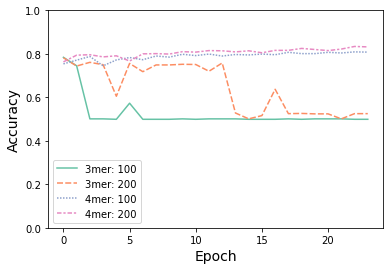

In [151]:
fig=plt.figure(figsize=(6,4))
p=sns.lineplot(data=eval34_acc, palette="Set2")
p.set_ylim([0.0,1.0])
p.set_ylabel("Accuracy", fontsize=14)
p.set_xlabel("Epoch", fontsize=14)
plt.show()

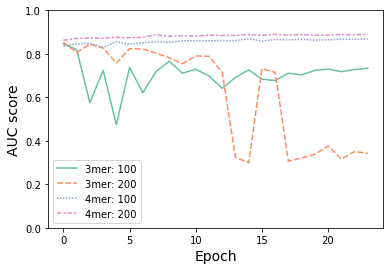

In [152]:
fig=plt.figure(figsize=(6,4))
p=sns.lineplot(data=eval34_auc, palette="Set2")
p.set_ylim([0.0,1.0])
p.set_ylabel("AUC score", fontsize=14)
p.set_xlabel("Epoch", fontsize=14)
plt.legend(loc="lower left")
plt.show()

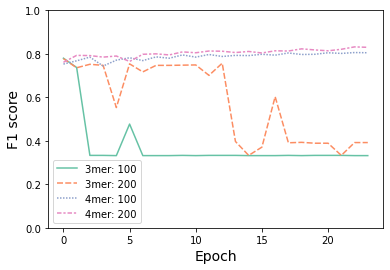

In [153]:
fig=plt.figure(figsize=(6,4))
p=sns.lineplot(data=eval34_f1, palette="Set2")
p.set_ylim([0.0,1.0])
p.set_ylabel("F1 score", fontsize=14)
p.set_xlabel("Epoch", fontsize=14)
plt.legend(loc="lower left")
plt.show()

In [24]:
eval3_ori_df=pd.read_csv(eval3_path, header=None, index_col=False, names=["k","acc","auc","f1","mcc","precision","recall"], sep="\s", engine="python")
eval4_ori_df=pd.read_csv(eval4_path, header=None, index_col=False, names=["k","acc","auc","f1","mcc","precision","recall"], sep="\s", engine="python")

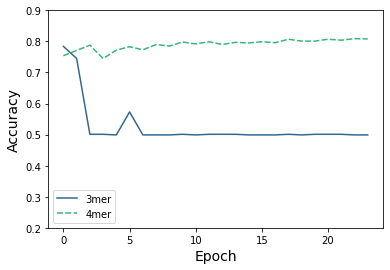

In [86]:
acc34=pd.concat([eval3["acc"],eval4["acc"]], axis=1)
acc34.columns=["3mer","4mer"]
fig=plt.figure(figsize=(6,4))
p=sns.lineplot(data=acc34, palette="viridis")
p.set_ylim([0.2,0.9])
p.set_ylabel("Accuracy", fontsize=14)
p.set_xlabel("Epoch", fontsize=14)
plt.show()

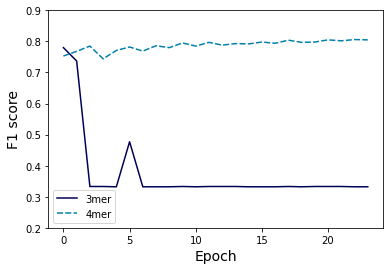

In [85]:
f34=pd.concat([eval3["f1"],eval4["f1"]], axis=1)
f34.columns=["3mer","4mer"]
fig=plt.figure(figsize=(6,4))
p=sns.lineplot(data=f34, palette="ocean")
p.set_ylim([0.2,0.9])
p.set_ylabel("F1 score", fontsize=14)
p.set_xlabel("Epoch", fontsize=14)
plt.show()

<AxesSubplot:>

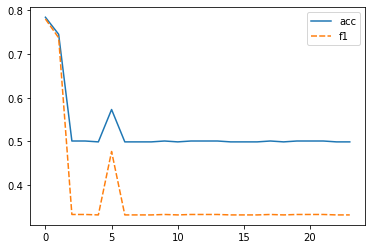

In [43]:
sns.lineplot(data=eval3[["acc","f1"]])

<AxesSubplot:>

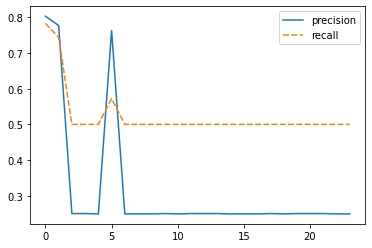

In [44]:
sns.lineplot(data=eval3[["precision","recall"]])

<AxesSubplot:>

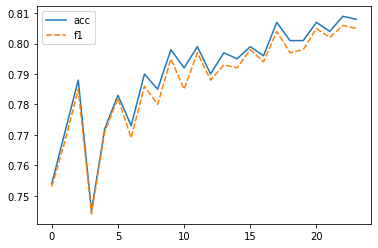

In [39]:
sns.lineplot(data=eval4[["acc","f1"]])

<AxesSubplot:ylabel='auc'>

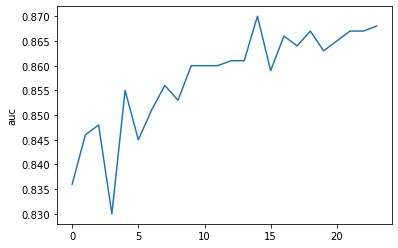

In [41]:
sns.lineplot(data=eval4["auc"])

<AxesSubplot:ylabel='mcc'>

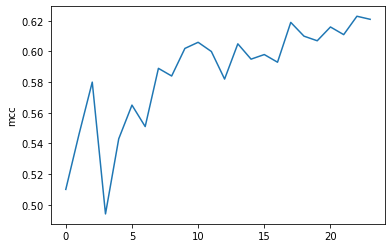

In [42]:
sns.lineplot(data=eval4["mcc"])

<AxesSubplot:>

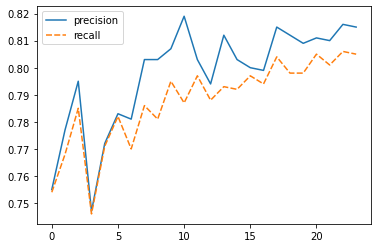

In [37]:
sns.lineplot(data=eval4[["precision","recall"]])

In [206]:
sample1_path=all_files[0]
df=bed2df_expanded(sample1_path)

In [207]:
all_unit_css=df2unitcss(df)

In [261]:
def remove15unit_css(all_unit_css):
    all_unit_css_wo15=[]
    for chr_unit_css in all_unit_css:
        chr_unit_css_wo15=[]
        for str_css in chr_unit_css:
            str_css=re.sub('O','', str_css)
            chr_unit_css_wo15.append(str_css)
        all_unit_css_wo15.append(chr_unit_css_wo15)
    return all_unit_css_wo15

In [262]:
all_unit_css_wo15=remove15unit_css(all_unit_css)

In [265]:
len(all_unit_css[0])

1246253

In [263]:
all_unit_css_wo15[15][10000:10200]

['',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'G',
 'G',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'G',
 'G',
 'B',
 'A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'B',
 'B',
 'B',
 'B',
 'F',
 'F',
 'F',
 'F',
 'F',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'B',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'B',
 'B',
 'G',
 'G',
 'G',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'D',
 'D',
 'F',
 'G',
 'G',
 'G',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'E',
 'E',
 'E',
 'E',
 'E',
 'G',
 'B',
 'B',
 'A',
 'A

In [242]:
sample_seq=all_unit_css[15][10000:10200]

In [243]:
colored_css_str_as_is(sample_seq)

OGGGGGGEEEEEEEGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGBAAAAABBBBBFFFFFCCCCCCCCCAAAAAAABBBEEEEEEEEEEEEEEEEEEEEEEEEBAAAAAAABBBGGGEEEEEEEEEEEEEEEEEEEEEDDFGGGBBBBBBBGGGGGGGGGEEEEEGBBAAABABBGGGGGGEEEEEEEEEEEEEMMLL


In [266]:
sample_seq=all_unit_css[8][10000:10200]

In [268]:
colored_css_str_as_is(sample_seq)

OOOOOOOOOOOOOOOOOOOOONNNNNNNNNNNNNNNNNNOOOOOOOOOOOOOOOOOOOOOOOOOOOOOGBBBAAAAAAAAAAAAAAAAAAAAABBBBGEEEEEEEEEEEEOOOOOEEEEEEEEEEEEEEEEEEEEEEEEGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE


In [269]:
sample_seq=all_unit_css[9][10000:10200]
colored_css_str_as_is(sample_seq)

OOOOOOOOOOOOOOIIIIIIIIIOOOOOOOOOOOOOOIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIOOOOOOOOOOOOOOOOOOOOOOOIIIIIIIIOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIIIIIIIIIIIIIIIIOOOOOOOOIIIOOOIIIIIIIIIIIIIIIIIIIO


In [11]:
chr1_4mer_pre=pd.read_csv("../database/pretrain/test_telo_v1/eval_results_chr1_4mer_v1_01.txt", header=None)

In [12]:
chr1_3mer_pre=pd.read_csv("../database/pretrain/test_telo_v1/eval_results_chr1_3mer_v1_01.txt", header=None)

In [13]:
eval_pre=pd.concat([chr1_4mer_pre,chr1_3mer_pre], axis=1)

In [14]:
eval_pre.columns=["4mer","3mer"]

In [15]:
eval_pre.head()

,4mer,3mer
0,2.721843,2.481082
1,1.426448,1.130136
2,1.213663,1.084043
3,1.141160,1.064191
4,1.100271,1.055811


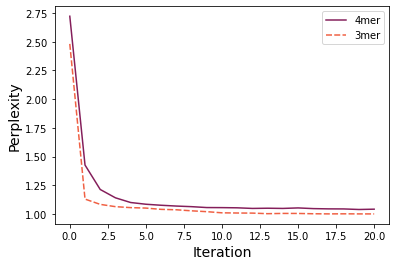

In [16]:
p=plt.figure(figsize=(6,4))
p=sns.lineplot(data=eval_pre, palette="rocket")
p.set_xlabel("Iteration", fontsize=14)
p.set_ylabel("Perplexity", fontsize=14)
plt.show()

In [17]:
sample1_path=all_files[0]
print(sample1_path)
df=bed2df_expanded(sample1_path)
df.head()

../database/bed/unzipped/E119_15_coreMarks_stateno.bed


,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,28400,15,28400,142,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,28400,28800,1,400,2,A,AA
2,chr1,28800,540400,15,511600,2558,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,713200,15,172400,862,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [18]:
import matplotlib.animation as animation

In [19]:
def all_chr_UnitCSS_Q_DistANIM(df,normalization=True):
    
    """
    input: df (the dataframe acquired by bed2df_expanded function for a chromatin state bed file)
    output: all_chr_q_index_norm (normalization ON) / all_chr_q_index (normalization OFF)
    option: normalization (all chromosome length= 0 to 1 for drawing a dist. graph)
    """
    
    all_unit_css=df2unitcss(df)  # a list of unit-css of df sample, chromosome wise
       
#     fig=plt.figure(figsize=(12,6))
#     ax = plt.subplot(111)
    all_chr_q_index=[] # list of list (raw data)
    all_chr_q_index_norm=[] # list of list (normalized data)
    
    fig = plt.figure(figsize=(12,6))
    ims=[]
    
    for i in tqdm_notebook(range(len(all_unit_css))):
        q_index=UnitCSS_Q_Dist(df, chr_no=i)
        all_chr_q_index.append(q_index)
        
        ########### normalization here ###########
        q_index_norm=[elm/q_index[-1] for elm in q_index]
        ##########################################
        all_chr_q_index_norm.append(q_index_norm)
        if i <=21:
            chr_name="chr"+str(i+1)
        elif i==23:
            chr_name="chrX"
        else:
            chr_name="chrY"

        grad_color=plt.cm.coolwarm(i*10)
#         ax.hist(q_index_norm, 100, color=grad_color, ec='white', alpha=0.5, label=chr_no)
#         im=ax.hist(q_index_norm, 50, color=grad_color, histtype="step", label=chr_name)
        im=plt.hist(q_index_norm, 50, color=grad_color, histtype="step", label=chr_name)
        ims.append(im)

    ### show only the normalized disribution
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]) # Shrink current axis's height by 20% on the bottom
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xlabel("Normalized Position")
#     plt.ylabel("number of 'O' state")
#     plt.grid(b=None)
    
    ani=animation.ArtistAnimation(fig, ims, interval=100000)
    plt.grid(b=None)
    plt.show()
    
    if normalization:
        return all_chr_q_index_norm
    else:
        return all_chr_q_index


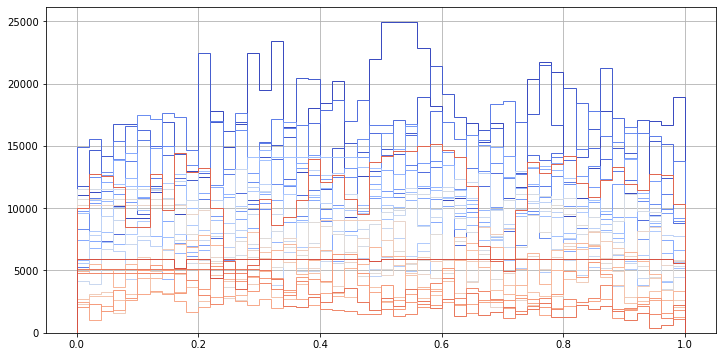

In [20]:
all_chr_q_index_norm=all_chr_UnitCSS_Q_DistANIM(df,normalization=True)

In [21]:
len(all_chr_q_index_norm[23])

294029

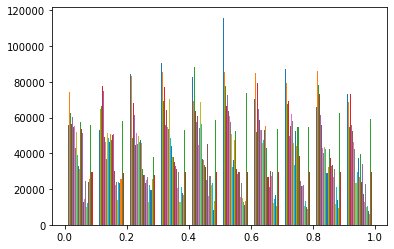

In [22]:
his_val=plt.hist(all_chr_q_index_norm)

In [23]:
ys=his_val[0]  # for 24, list of list

In [24]:
ys[0]

array([ 56004.,  52946.,  84364.,  90362.,  82444., 115847.,  70499.,
        87177.,  66057.,  72894.])

In [25]:
xs=his_val[1]

In [26]:
xs[1:]

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [168]:
plt.bar(xs[1:], ys[0])
plt.show()

In [154]:
xs_arr=[xs]*len(ys)

In [126]:
n = 100
number_of_frames = 10
data = 

In [135]:
type(data)

numpy.ndarray

In [183]:
np.random.seed(19680801)
# Fixing bin edges
HIST_BINS = xs

# histogram our data with numpy
data = ys[0]
n, _ = np.histogram(data, HIST_BINS)

In [184]:
data.shape

(10,)

In [185]:
HIST_BINS.shape

(11,)

In [34]:
xs[1:]

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [35]:
ys[0]

array([ 56004.,  52946.,  84364.,  90362.,  82444., 115847.,  70499.,
        87177.,  66057.,  72894.])

In [47]:
fig, ax = plt.subplots()
hist = ax.hist(all_chr_q_index_norm[0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


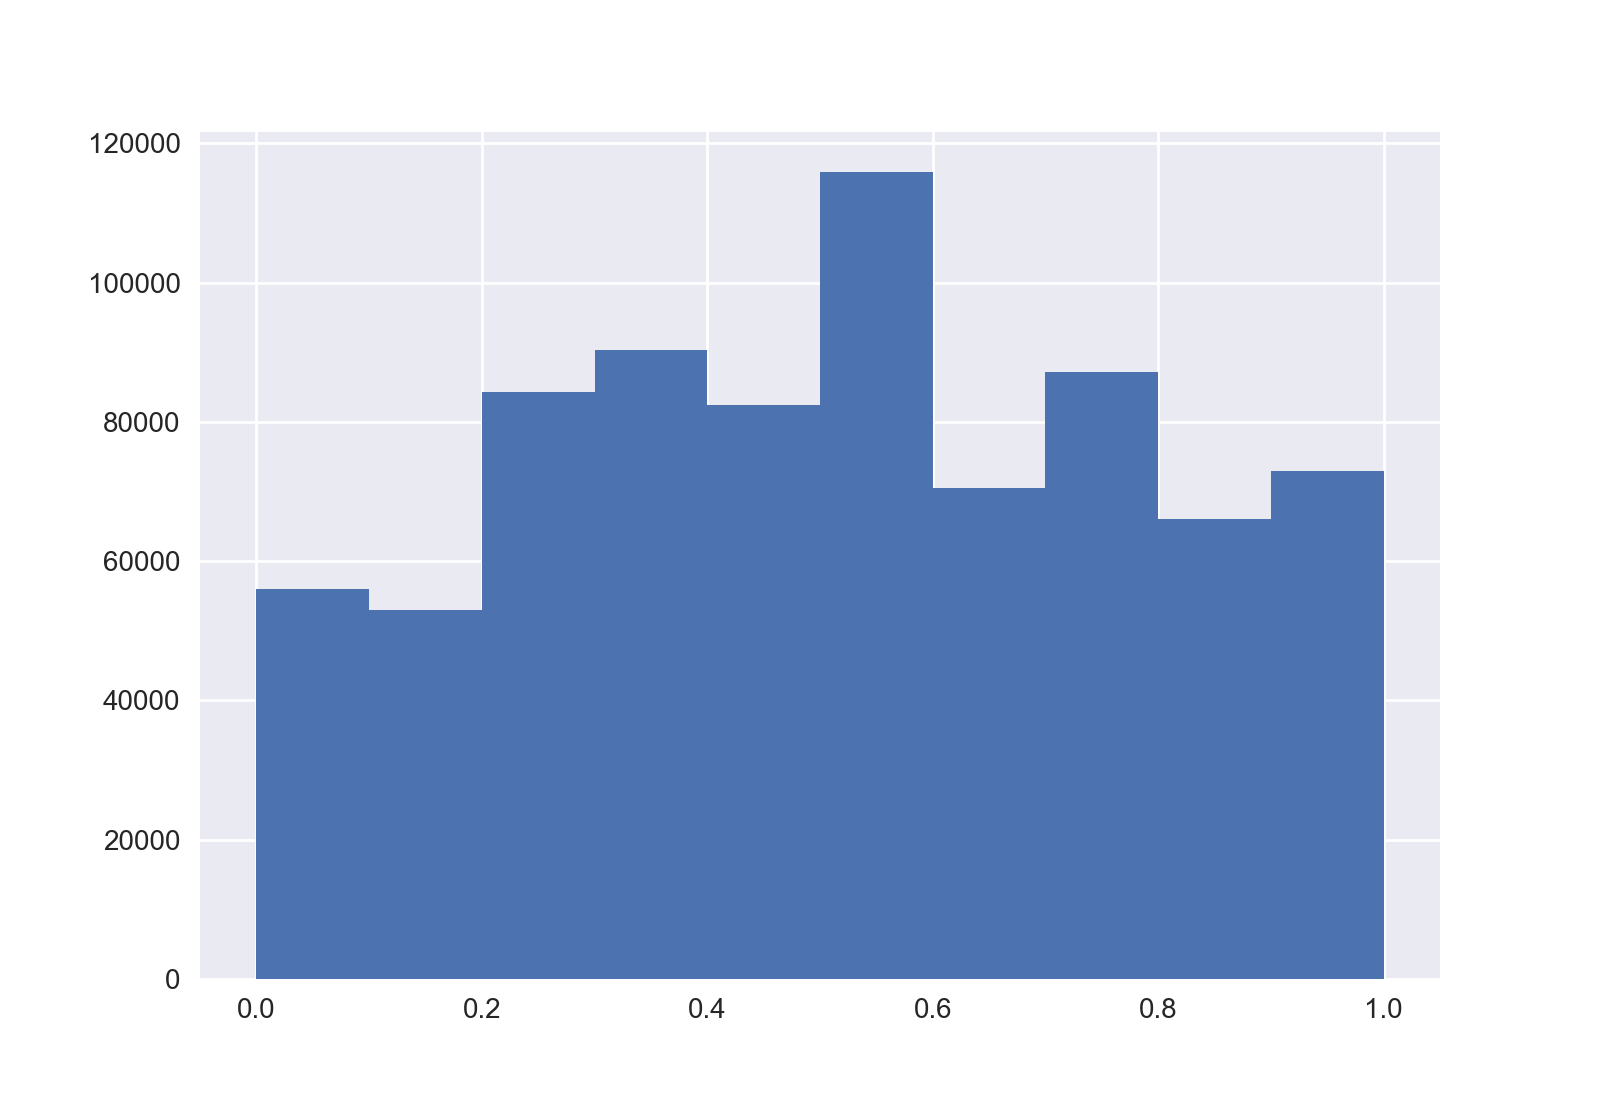

In [159]:
fig, ax = plt.subplots()

x = xs
hist = ax.hist(all_chr_q_index_norm[0])


def animate(i):
    hist=all_chr_q_index_norm[i]
#     line.set_ydata(np.sin(x + i/10.0))  # update the data
    return hist


# Init only required for blitting to give a clean slate.
def init():
    hist.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 23), init_func=init,interval=25, blit=True) # , )
                          
plt.show()

In [87]:
# Fixing random state for reproducibility
# np.random.seed(19680801)
# Fixing bin edges
# HIST_BINS = np.linspace(-4, 4, 100)
HIST_BINS = np.linspace(0, 1, 50)

# histogram our data with numpy
# data = np.random.randn(1000)
data = all_chr_q_index_norm[0]
n, _ = np.histogram(data, HIST_BINS)

In [145]:
cm = plt.cm.get_cmap('viridis')
tot_frame=len(all_chr_q_index_norm)
color=[]
for c in range(tot_frame):
    color.append(cm(c*10))

In [188]:
def prepare_animation(bar_container):
#     for bar in bar_container:
#         print(bar.get_facecolor())

    def animate(frame_number):
        # simulate new data coming in
        print("frame_number: ", frame_number)
#         lab="Chr_"+str(frame_number)
        
        
        data = all_chr_q_index_norm[frame_number]
#         n, _ = np.histogram(data, HIST_BINS)
        n, _ = np.histogram(data, HIST_BINS)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
#             bar_container.patches.Patch(facecolor="red")
        return bar_container.patches

#         L.get_texts()[0].set_text(lab)
    
    return animate

<IPython.core.display.Javascript object>


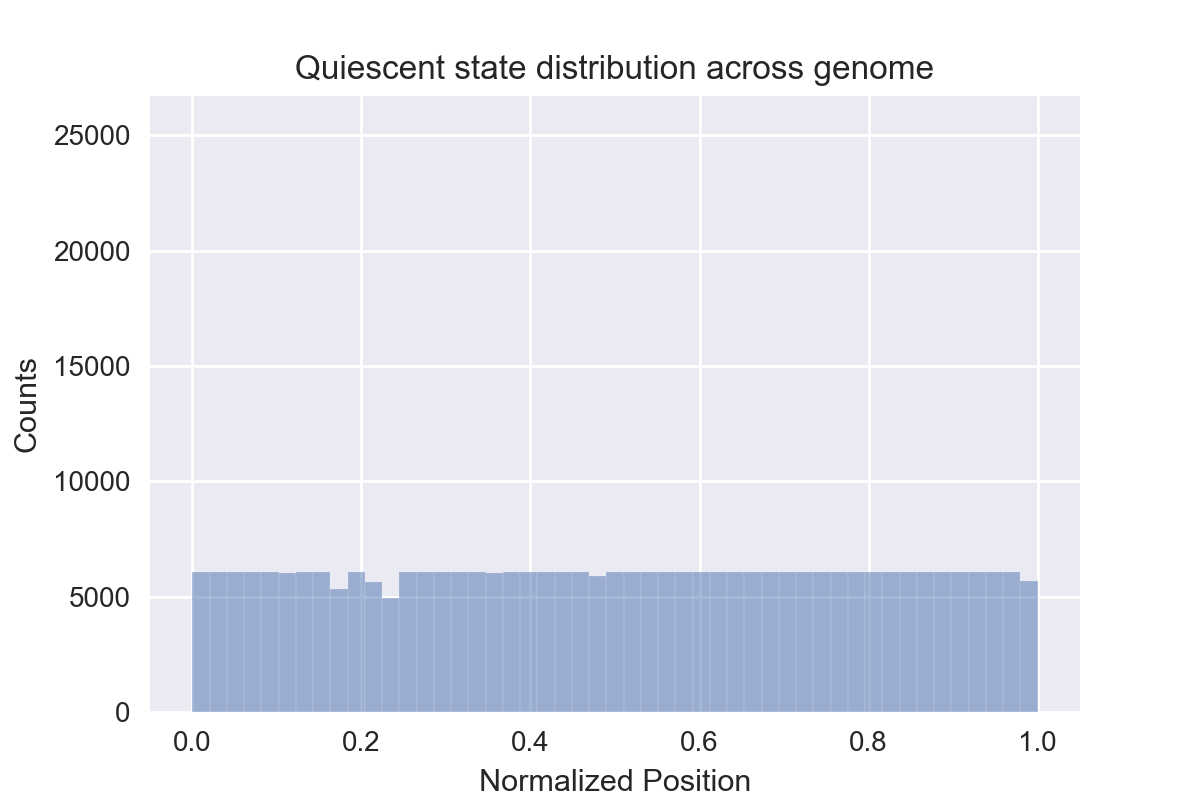

In [190]:
fig, ax = plt.subplots(figsize=(6,4))
_, _, bar_container = ax.hist(data, HIST_BINS, lw=0.1,
                              ec="white", alpha=0.5)

# L=plt.legend(loc=1)
# L.get_texts()[0].set_text(lab)

# bar_con_all=[]
# def colored_bar(data,HIST_BINS):
#     _, _, bar_container = ax.hist(data, HIST_BINS, lw=0.1,
#                               ec="white", fc=color(i), alpha=0.5)
#     bar_con_all.append(bar_container)
#     return bar_con_all

ani = animation.FuncAnimation(fig, prepare_animation(bar_container), frames=len(all_chr_q_index_norm), interval=500,
                              repeat=False, blit=True)

plt.title("Quiescent state distribution across genome")
plt.xlabel("Normalized Position")
plt.ylabel("Counts")
plt.show()

In [179]:
my_writer=animation.PillowWriter(fps=3, codec='libx264', bitrate=2)

ani.save(filename='../database/qstate_dist_test.gif', writer=my_writer)
# ani.save('../database/qstate_dist_test.mp4', writer="ffmpeg")

In [180]:
ani.save('../database/qstate_dist_test.mp4', writer="ffmpeg")

<IPython.core.display.Javascript object>


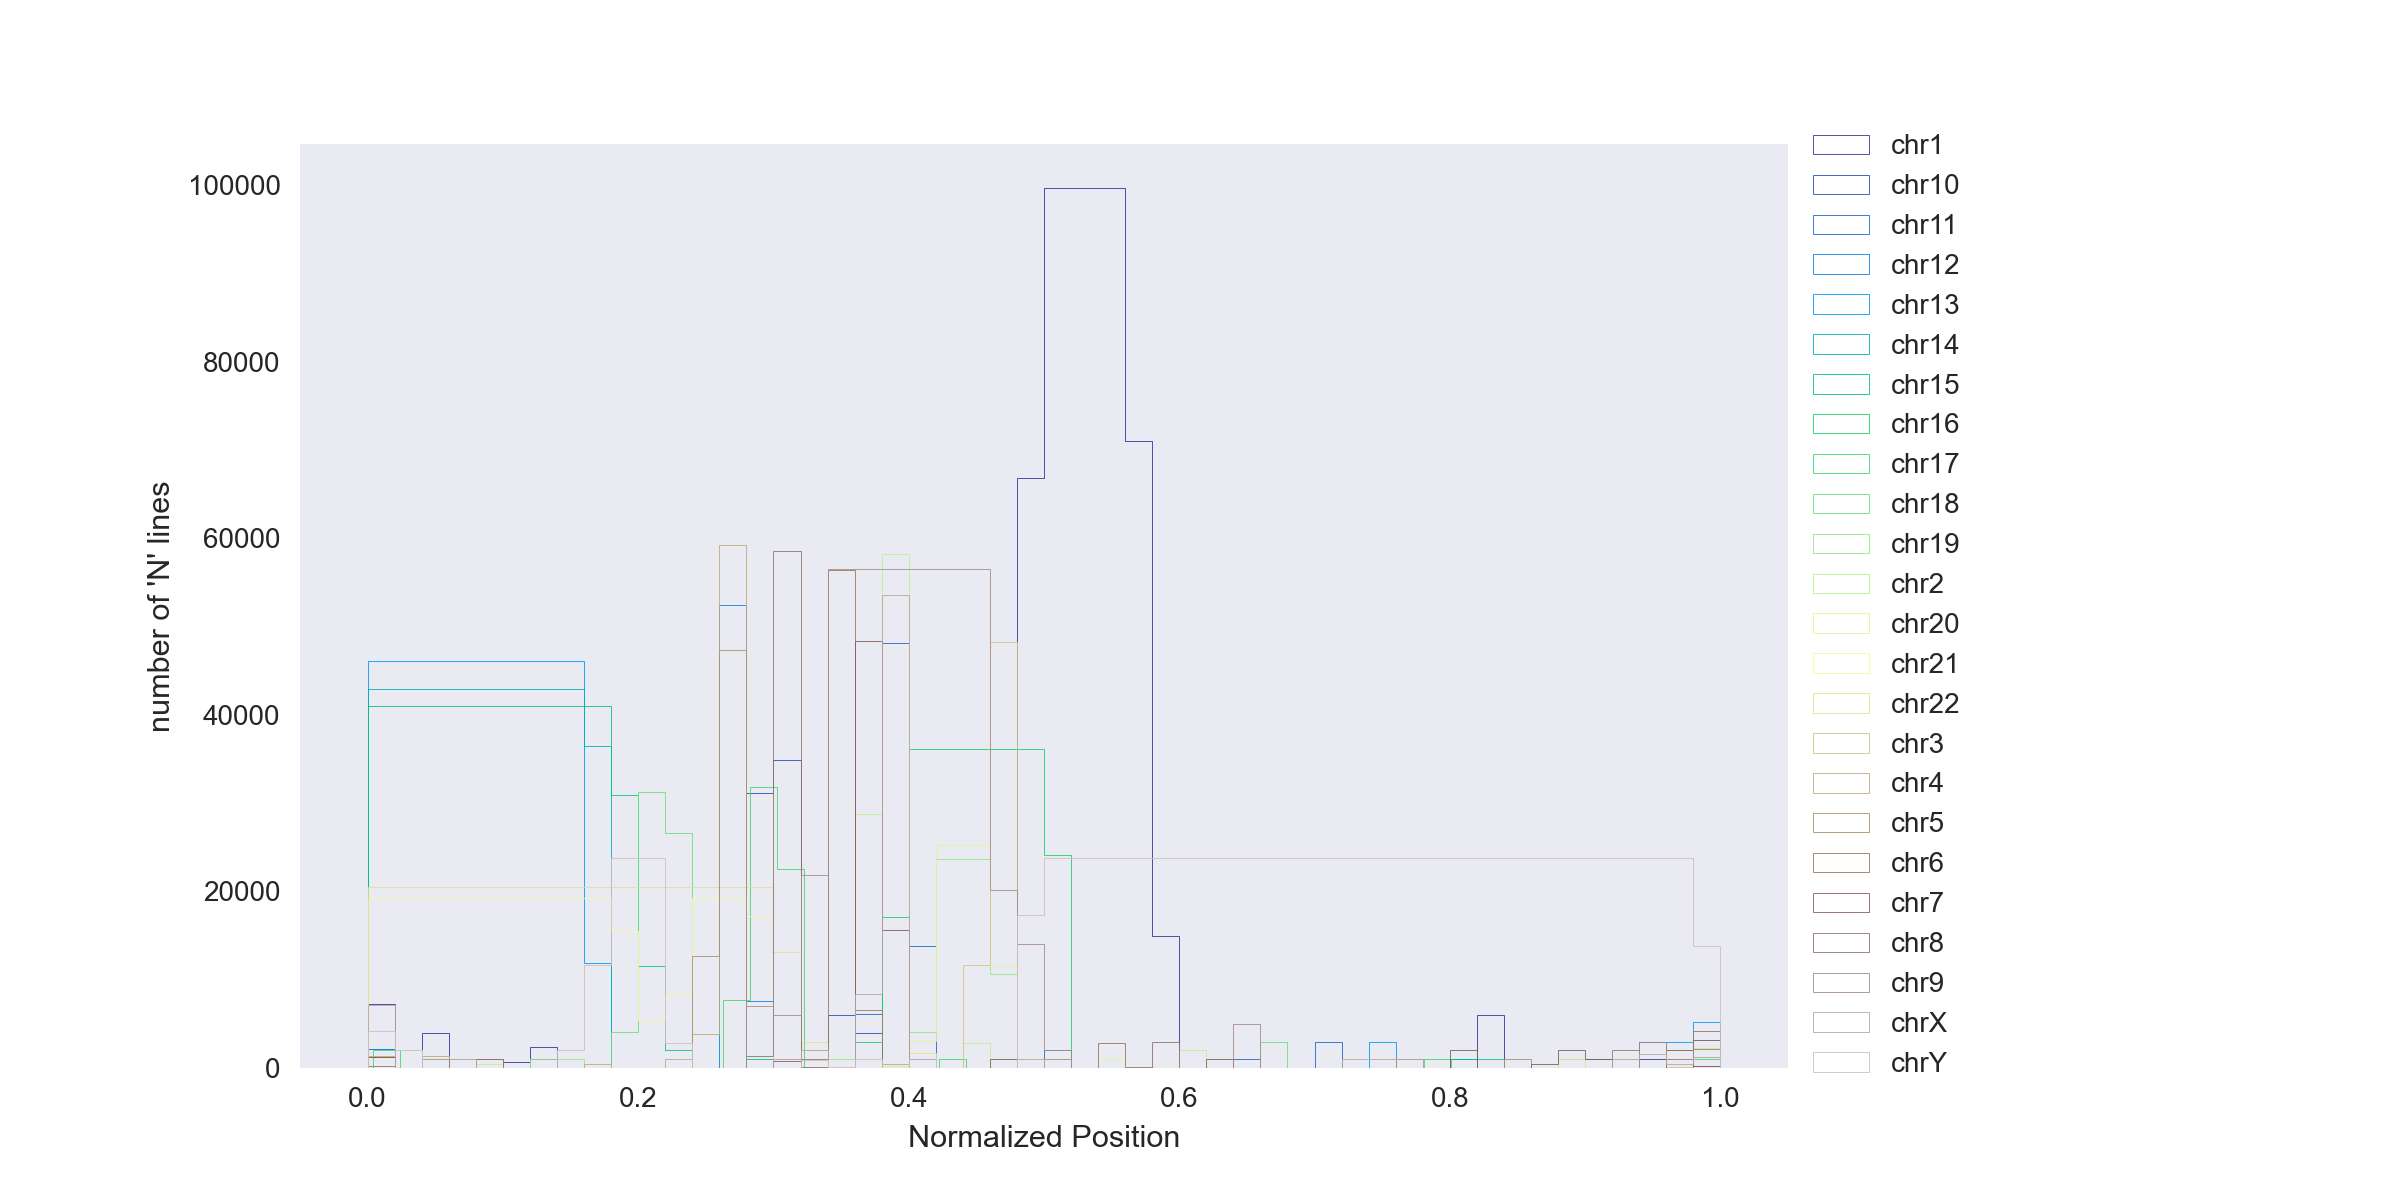

In [191]:
all_chr_n_index_norm=all_chr_Ndist(ref_genome_path='../database/hg19/genome_per_chr/', normalization=True)

In [193]:
type(all_chr_n_index_norm[0])

list

In [194]:
HIST_BINS = np.linspace(0, 1, 50)

# histogram our data with numpy
# data = np.random.randn(1000)
data = all_chr_n_index_norm[0]
n, _ = np.histogram(data, HIST_BINS)

In [204]:
def prepare_animation(bar_container):
#     for bar in bar_container:
#         print(bar.get_facecolor())

    def animate(frame_number):
        # simulate new data coming in
        print("frame_number: ", frame_number)
#         lab="Chr_"+str(frame_number)
        
        
        data = all_chr_n_index_norm[frame_number]
#         n, _ = np.histogram(data, HIST_BINS)
        n, _ = np.histogram(data, HIST_BINS)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
#             bar_container.patches.Patch(facecolor="red")
        return bar_container.patches

#         L.get_texts()[0].set_text(lab)
#     print(L.get_texts()[0])
    
    return animate

In [205]:
fig, ax = plt.subplots(figsize=(6,4))
_, _, bar_container = ax.hist(data, HIST_BINS, lw=0.1,
                              ec="white", fc="teal", alpha=0.5)

L=plt.legend(loc=1)
L.get_texts()[0].set_text(lab)

# bar_con_all=[]
# def colored_bar(data,HIST_BINS):
#     _, _, bar_container = ax.hist(data, HIST_BINS, lw=0.1,
#                               ec="white", fc=color(i), alpha=0.5)
#     bar_con_all.append(bar_container)
#     return bar_con_all

ani2 = animation.FuncAnimation(fig, prepare_animation(bar_container), frames=len(all_chr_n_index_norm), interval=500,
                              repeat=False, blit=True)

plt.title("'N' distribution across genome")
plt.xlabel("Normalized Position")
plt.ylabel("Counts")
plt.show()

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


IndexError: list index out of range

In [201]:
ani2.save('../database/visual/Nstate_dist_test.mp4', writer="ffmpeg")

frame_number:  0
frame_number:  0
frame_number:  1
frame_number:  2
frame_number:  3
frame_number:  4
frame_number:  5
frame_number:  6
frame_number:  7
frame_number:  8
frame_number:  9
frame_number:  10
frame_number:  11
frame_number:  12
frame_number:  13
frame_number:  14
frame_number:  15
frame_number:  16
frame_number:  17
frame_number:  18
frame_number:  19
frame_number:  20
frame_number:  21
frame_number:  22
frame_number:  23


In [111]:
cm = plt.cm.get_cmap('RdYlBu_r')

In [114]:
cm(0)

(0.19215686274509805, 0.21176470588235294, 0.5843137254901961, 1.0)

In [117]:
cm(24)

(0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0)

In [120]:
color

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725, 1.0),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765, 1.0),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353, 1.0),
 (0.2, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.984313725490196, 0.6039215686274509, 0.6, 1.0),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745, 1.0),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883, 1.0),
 (1.0, 0.4980392156862745, 0.0, 1.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098, 1.0),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509, 1.0),
 (1.0, 1.0, 0.6, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.694

In [133]:
cm = plt.cm.get_cmap('viridis')
tot_frame=len(all_chr_q_index_norm)
color=[]
for c in range(tot_frame):
    color.append(cm(c*10))

In [134]:
color

[(0.267004, 0.004874, 0.329415, 1.0),
 (0.278791, 0.062145, 0.386592, 1.0),
 (0.283197, 0.11568, 0.436115, 1.0),
 (0.280255, 0.165693, 0.476498, 1.0),
 (0.270595, 0.214069, 0.507052, 1.0),
 (0.255645, 0.260703, 0.528312, 1.0),
 (0.237441, 0.305202, 0.541921, 1.0),
 (0.21813, 0.347432, 0.550038, 1.0),
 (0.19943, 0.387607, 0.554642, 1.0),
 (0.182256, 0.426184, 0.55712, 1.0),
 (0.166617, 0.463708, 0.558119, 1.0),
 (0.151918, 0.500685, 0.557587, 1.0),
 (0.13777, 0.537492, 0.554906, 1.0),
 (0.125394, 0.574318, 0.549086, 1.0),
 (0.119423, 0.611141, 0.538982, 1.0),
 (0.128087, 0.647749, 0.523491, 1.0),
 (0.157851, 0.683765, 0.501686, 1.0),
 (0.20803, 0.718701, 0.472873, 1.0),
 (0.274149, 0.751988, 0.436601, 1.0),
 (0.35236, 0.783011, 0.392636, 1.0),
 (0.440137, 0.811138, 0.340967, 1.0),
 (0.535621, 0.835785, 0.281908, 1.0),
 (0.636902, 0.856542, 0.21662, 1.0),
 (0.741388, 0.873449, 0.149561, 1.0)]

In [66]:
whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'

In [67]:
g_lst_chr=whGene2GLChr(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed')

Extracting the gene file ...
Done!


In [68]:
len(g_lst_chr)

24

In [9]:
df_lst_chr=df2chr_df(df)

In [10]:
# make a long string of the css (not using unit, but the real length)

def df2longcss(df):
    df_lst_chr=df2chr_df(df)
    # remove the microchondria DNA from df_lst_chr
    if df_lst_chr[-3]["chromosome"].iloc[0]=="chrM":
        del df_lst_chr[-3]
        assert df_lst_chr[-3]["chromosome"].iloc[0]=="chr22"
    else:   
        assert df_lst_chr[-3]["chromosome"].iloc[0]=="chr22"
    
    all_css=[]
    for i in range(len(df_lst_chr)):
        df_chr=df_lst_chr[i]
        css_chr=''
        for j in range(len(df_chr)):
            css_chr+=df_chr["length"].iloc[j]*df_chr["state_seq"].iloc[j]
        all_css.append(css_chr)  
    return all_css    # list of css per chromosome in a cell

In [11]:
all_css=df2longcss(df)

In [12]:
len(all_css[0])

249250600

In [13]:
a,b=0,6

In [14]:
all_css[0][a:b]

'OOOOOO'

In [15]:
def compGene2css(whole_gene_file,df):
    g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(g_lst_chr)
    
    css_gene_lst_all=[]
    for i in range(total_chr):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        css_gene_lst_chr=[]
        for j in range(len(gene_df)):
            g_start=gene_df["TxStart"].iloc[j]-1  # python counts form 0
            g_end=gene_df["TxEnd"].iloc[j]+1      # python excludes the end
            
            css_gene=css[g_start:g_end]           # cut the gene area only
            css_gene_lst_chr.append(css_gene)     # store in the list
          
        css_gene_lst_all.append(css_gene_lst_chr)  # list of list
    
    assert len(css_gene_lst_all)==total_chr
    return css_gene_lst_all


In [16]:
css_gene_lst_all=compGene2css(whole_gene_file,df)

In [17]:
len(css_gene_lst_all)

24

In [18]:
a="AAJJJJ"
"A" in a

True

In [19]:
css_gene_lst_all[0][3]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

#### How many gene contains quiescent state?

In [20]:
# sum overall : for cell-wise
q_cnt=0
not_q_cnt=0
for i in range(len(css_gene_lst_all)):
    css_gene_lst=css_gene_lst_all[i]
    for j in range(len(css_gene_lst)):
        css_gene=css_gene_lst[j]
        if "O" in css_gene:
            q_cnt+=1
        else:
            not_q_cnt+=1
print("No. of gene contains quiescent state: ", q_cnt)
print("No. of gene does not quiescent state: ", not_q_cnt)

No. of gene contains quiescent state:  28832
No. of gene does not quiescent state:  23428


In [21]:
# make it a list of list : for chromosome-wise
q_cnt_lst=[]
not_q_cnt_lst=[]
for i in range(len(css_gene_lst_all)):
    css_gene_lst=css_gene_lst_all[i]
    
    q_cnt=0
    not_q_cnt=0
    for j in range(len(css_gene_lst)):
        css_gene=css_gene_lst[j]
        if "O" in css_gene:
            q_cnt+=1
        else:
            not_q_cnt+=1
    q_cnt_lst.append(q_cnt)
    not_q_cnt_lst.append(not_q_cnt)
    
print("No. of gene contains quiescent state: ", q_cnt_lst[0])
print("No. of gene does not quiescent state: ", not_q_cnt_lst[0])

No. of gene contains quiescent state:  2693
No. of gene does not quiescent state:  2562


In [22]:
np.sum(q_cnt_lst)

28832

#### And is it differ depending upon cell types?

In [23]:
# for cell-wise count : how many 15th-including genes are there per cell

def QnonQforCell(all_files=all_files,whole_gene_file=whole_gene_file):
    total_cells=len(all_files)
    
    q_cnt_lst=[]
    not_q_cnt_lst=[]
    for i in range(total_cells):
        cell_path=all_files[i]
        df=bed2df_expanded(cell_path)
        css_gene_lst_all=compGene2css(whole_gene_file,df)
        
        q_cnt=0
        not_q_cnt=0
        for j in range(len(css_gene_lst_all)):
            css_gene_lst=css_gene_lst_all[j]
            for k in range(len(css_gene_lst)):
                css_gene=css_gene_lst[k]
                if "O" in css_gene:
                    q_cnt+=1
                else:
                    not_q_cnt+=1
        q_cnt_lst.append(q_cnt)
        not_q_cnt_lst.append(not_q_cnt)
    return q_cnt_lst, not_q_cnt_lst

#### And is it differ depending upon chromosome?

In [24]:
q_cnt_lst, not_q_cnt_lst=QnonQforCell(all_files,whole_gene_file)

In [25]:
np.mean(q_cnt_lst)

25451.889763779527

In [26]:
np.mean(not_q_cnt_lst)

26808.110236220473

In [27]:
# print("No. of cell types: ",len(all_files))

def QnonQforChr(all_files=all_files,whole_gene_file=whole_gene_file):
#     import itertools
    total_cells=len(all_files)
    
    q_cnt_lst_all=[]
    not_q_cnt_lst_all=[]
    for i in range(total_cells):
        cell_path=all_files[i]
        df=bed2df_expanded(cell_path)
        css_gene_lst_all=compGene2css(whole_gene_file,df)
        
        q_cnt_lst=[]
        not_q_cnt_lst=[]
        for j in range(len(css_gene_lst_all)):
            css_gene_lst=css_gene_lst_all[j]
            
            q_cnt=0
            not_q_cnt=0
            for k in range(len(css_gene_lst)):
                css_gene=css_gene_lst[k]
                if "O" in css_gene:
                    q_cnt+=1
                else:
                    not_q_cnt+=1
                    
            q_cnt_lst.append(q_cnt)
            not_q_cnt_lst.append(not_q_cnt)        
        q_cnt_lst_all.append(q_cnt_lst)
        not_q_cnt_lst_all.append(not_q_cnt_lst)

#     flatten the list of list and make it into list
    q_cnt_lst_all=list(itertools.chain.from_iterable(q_cnt_lst_all))
    not_q_cnt_lst_all=list(itertools.chain.from_iterable(not_q_cnt_lst))
        
    return q_cnt_lst_all, not_q_cnt_lst_all

In [28]:
q_cnt_lst_all, not_q_cnt_lst_all=QnonQforChr(all_files,whole_gene_file)

TypeError: 'int' object is not iterable

In [ ]:
# q_cnt_lst_all=list(itertools.chain.from_iterable(q_cnt_lst_all))
not_q_cnt_lst_all=list(itertools.chain.from_iterable(not_q_cnt_lst_all))

In [ ]:
len(not_q_cnt_lst_all)

In [ ]:
def QnonQforCellHistT1(q_cnt_lst, not_q_cnt_lst, bin_size=15):
    """Run this after executing QnonQforCell"""
    data_w=q_cnt_lst
    data_wo=not_q_cnt_lst

    mu_w, std_w=norm.fit(data_w)
    mu_wo, std_wo=norm.fit(data_wo)

    plt.hist(data_w, bins=bin_size, alpha=0.3, color="k")
    plt.hist(data_wo, bins=bin_size, alpha=0.5, color="r")

#     xmin_w, xmax_w=plt.xlim()
#     xmin_wo, xmax_wo=plt.xlim()

#     x_w = np.linspace(xmin_w, xmax_w, 100)
#     p_w = norm.pdf(x_w, mu_w, std)
#     x_wo = np.linspace(xmin_wo, xmax_wo, 100)
#     p_wo = norm.pdf(x_wo, mu_wo, std)

#     plt.plot(x_w, p_w, "r", linewidth=2)
#     plt.plot(x_wo, p_wo, "k", linewidth=2)

    title='Number of Genic region with/without Quiescent state'
    plt.title(title)
#     plt.legend("with Quiescent state","without Quiescent state")
    plt.xlabel("No. of Genes")
    plt.ylabel("Counts")
    plt.show()

In [ ]:
QnonQforCellHistT1(q_cnt_lst, not_q_cnt_lst,10)  # per cell, how many genes with/out o per cell

In [ ]:
QnonQforCellHistT1(q_cnt_lst_all, not_q_cnt_lst_all,20)  # total gene in all samples (more detailed)

In [ ]:
def QnonQforCellHistT2(q_cnt_lst, not_q_cnt_lst,bin_size):
    """Run this after executing QnonQforCell"""
    data_w=q_cnt_lst
    data_wo=not_q_cnt_lst

    mu_w, std_w=norm.fit(data_w)
    mu_wo, std_wo=norm.fit(data_wo)

    fig=plt.figure(figsize=(8,4))
    ax=fig.add_subplot(1,1,1)
    ax.hist([data_w,data_wo], bins=bin_size, alpha=0.5, color=["teal","orange"], label=["with Quiescent state","without Quiescent state"])

#     xmin_w, xmax_w=plt.xlim()
#     xmin_wo, xmax_wo=plt.xlim()

#     x_w = np.linspace(xmin_w, xmax_w, 100)
#     p_w = norm.pdf(x_w, mu_w, std)
#     x_wo = np.linspace(xmin_wo, xmax_wo, 100)
#     p_wo = norm.pdf(x_wo, mu_wo, std)

    ax.legend(loc="upper left")

#     plt.plot(x_w, p_w, "teal", linewidth=2)
#     plt.plot(x_wo, p_wo, "orange", linewidth=2)

    title='Number of Genic region with/without Quiescent state'
    plt.title(title)
    plt.legend()
    plt.xlabel("No. of Genes")
    plt.ylabel("Counts")
    plt.show()

In [ ]:
QnonQforCellHistT2(q_cnt_lst, not_q_cnt_lst,10)

In [ ]:
QnonQforCellHistT2(q_cnt_lst_all, not_q_cnt_lst_all,20)

#### No. of 15 state in the genic region?

In [ ]:
len(css_gene_lst_all) # list of list, per chromosome

In [ ]:
css_gene_lst_all[0][0].count("O") # built-in function count

In [ ]:
# generate thee lists: 15th state-including gene count, gene length, proportion of 15th state per gene
def cntQinGene(css_gene_lst_all):
    """run this after executing compGene2css(whole_gene_file,df)
       [Input]
       css_gene_lst_all : list of css list of each chromosome
       [Output]
       cnt_o_lst : list of Quiescent state counts list per chromosome
       gene_len_lst : list of gene length (in terms of chromatin state Anno.200bps) list per chromosome
       pro_o_lst : list of proportion of Quiescent state per gene list per chromosome
    """
    cnt_o_lst=[]
    gene_len_lst=[]
    pro_o_lst=[]
    for i in range(len(css_gene_lst_all)):
        css_gene_lst=css_gene_lst_all[i]
        
        cnt_o_chr=[]
        gene_len_chr=[]
        pro_o_chr=[]
        for j in range(len(css_gene_lst)):
            css_gene=css_gene_lst[j]
            cnt_o=css_gene.count("O")
            gene_len=len(css_gene)
            pro_o=cnt_o/gene_len
            
            cnt_o_chr.append(cnt_o)
            gene_len_chr.append(gene_len)
            pro_o_chr.append(pro_o)
            
        cnt_o_lst.append(cnt_o_chr)
        gene_len_lst.append(gene_len_chr)
        pro_o_lst.append(pro_o_chr)
        
    return cnt_o_lst, gene_len_lst, pro_o_lst

In [ ]:
cnt_o_lst, gene_len_lst, pro_o_lst=cntQinGene(css_gene_lst_all)

In [ ]:
pro_o_lst[0][500]

In [ ]:
cnt_o_lst[0][500]

In [ ]:
gene_len_lst[0][500]

In [ ]:
#flatten
cnt_o_lst=list(itertools.chain.from_iterable(cnt_o_lst))
gene_len_lst=list(itertools.chain.from_iterable(gene_len_lst))
pro_o_lst=list(itertools.chain.from_iterable(pro_o_lst))

In [ ]:
fig=plt.figure(figsize=(4,6))
plt.boxplot([cnt_o_lst, gene_len_lst])
plt.show()

In [ ]:
fig=plt.figure(figsize=(4,3))
plt.boxplot(pro_o_lst)
plt.show()

In [ ]:
plt.hist(pro_o_lst, bins=100, density=True, log=True, alpha=0.5, color="r" )
plt.title("Proportion of 15th state in genes")
plt.show()


In [ ]:
df.tail()

In [ ]:
# divide into two step

# step 1. just divide into Q-included, Q-excluded
# pre-requisite: run function "compGene2css(whole_gene_file,df)"  to create 'css_gene_lst_all'
# input : css_gene_lst_all (whole gene in a cell per chromosome, represented as css anno.)
# output : q_gene_lst, non_q_gene_lst (flatten)

def QnonQgene(css_gene_lst_all):
    """
    Prerequisite: run the function "compGene2css" to get 'css_gene_lst_all'
    input: css_gene_lst_all
    output: q_gene, non_q_gene, flatten lists of the gene containing 15th/ without 15th
    """
    css_gene_lst_all_f=list(itertools.chain.from_iterable(css_gene_lst_all)) # flatten the list of list
    total_gene=len(css_gene_lst_all_f) # in a specific cell (here, df)
    
    q_gene_lst=[]      # prepare the list of q_anno. included gene
    non_q_gene_lst=[]  # prerpare the list of the whole non_q_anno. gene
    
    for i in range(total_gene):
        if "O" in css_gene_lst_all_f[i]:
            q_gene_lst.append(css_gene_lst_all_f[i])
        else:
            non_q_gene_lst.append(css_gene_lst_all_f[i])
    return q_gene_lst, non_q_gene_lst

In [ ]:
q_gene_lst, non_q_gene_lst=QnonQgene(css_gene_lst_all)

In [ ]:
len(non_q_gene_lst)

In [ ]:
# step 2. 
# How is the composition of the gene (css) that are NOT annotated with 15th state?

def QNonQcomp_count(q_gene_lst, non_q_gene_lst):
    """
    [Input]
    q_gene_lst, non_q_gene_lst : acquired by running 'QnonQgene(css_gene_lst_all)'
    
    [Output]
    2. q_dict_lst: list of dictionary of which key=state, value=count, for a gene containing 15th state
    3. q_count_lst: list of counts, the no. of composition of the gene containing 15th state
    5. non_q_dict_lst: counterpart of 2. without 15th
    6. non_q_count_lst: counterpart of 3. without 15th
    """   
    q_dict_lst=[] # to store the dict list (list of dictionary)
    q_count_lst=[]  # list of a number (list of numbers)
    
    non_q_dict_lst=[]  # to store the dict list (list of dictionary)
    non_q_count_lst=[]  # list of a number (list of numbers)
   
    for gene_q in q_gene_lst:
        q_uniq_set=set(gene_q)
        q_dict=dict.fromkeys(gene_q,0) # prerpare the initial dictionary (state-count)
        for key in q_dict.keys():
            q_dict[key]=gene_q.count(key)

        q_dict_lst.append(q_dict)  # to return
        q_count_lst.append(len(q_dict))  # to return
                
        #### do the same thing for q -included gene

    for non_gene_q in non_q_gene_lst:
        non_q_uniq_set=set(non_gene_q)
        non_q_dict=dict.fromkeys(non_gene_q,0) # prerpare the initial dictionary (state-count)

        for key in non_q_dict.keys():
            non_q_dict[key]=non_gene_q.count(key)

        non_q_dict_lst.append(non_q_dict)
        non_q_count_lst.append(len(non_q_dict))
    
    assert len(q_dict_lst)==len(q_count_lst)
    assert len(non_q_dict_lst)==len(non_q_count_lst)
    
    return q_dict_lst, q_count_lst, non_q_dict_lst, non_q_count_lst


In [ ]:
q_dict_lst, q_count_lst, non_q_dict_lst, non_q_count_lst=QNonQcomp_count(q_gene_lst, non_q_gene_lst)

In [ ]:
len(non_q_dict_lst)

In [ ]:
len(non_q_count_lst)

In [ ]:
plt.hist(q_count_lst, bins=10, alpha=0.9, color="teal", edgecolor="w")
plt.title("No. of composition in genic region including Quiescent state")
plt.show()

In [ ]:
plt.hist(non_q_count_lst, bins=10, alpha=0.9, color="orange", edgecolor="w")
plt.title("No. of composition in genic region without Quiescent state")
plt.show()

In [ ]:
def QnonQcomp_state(q_gene_lst, non_q_gene_lst):
    
    

In [47]:
# How is the composition of the gene (css) that are NOT annotated with 15th state?

def QNonQcompChr(whole_gene_file, df):
    """
    [Input]
    1. whole_gene_file: gene position table hg19
    2. df: dataframe of a specific cell acquired by the func 'bed2df_expanded' 
    
    [Output]
    1. non_q_lst: list of the whole gene (as a css annotated) without 15th state
    2. non_q_dict_lst: list of dictionary of which key=state, value=count, for a gene without 15th state
    3. non_q_count_lst: list of counts, the no. of composition of the gene without 15th state
    4. q_lst: counterpart of 1. non_q_lst
    5. q_dict_lst: counterpart of 2. non_q_dict_lst
    6. q_count_lst: counterpart of 3. non_q_count_lst
    """
    
    css_gene_lst_all=compGene2css(whole_gene_file,df)  # list of list of gene (represented as css anno.) in a chromosome    
    css_gene_lst_all_f=list(itertools.chain.from_iterable(css_gene_lst_all)) # flatten the list of list
    total_gene=len(css_gene_lst_all_f) # in a specific cell (here, df)
    
    non_q_lst=[]  # prerpare the list of the whole non_q_anno. gene
    non_q_dict_lst=[]  # to store the dict list (list of dictionary)
    non_q_count_lst=[]  # list of a number (list of numbers)
    
    q_lst=[]  # prepare the list of q_anno. included gene
    q_dict_lst=[] # to store the dict list (list of dictionary)
    q_count_lst=[]  # list of a number (list of numbers)
    
    for i in range(total_gene):
        if "O" not in css_gene_lst_all_f[i]:
            non_q_lst.append(css_gene_lst_all_f[i])   # list of non Q           
#             non_q_dict_lst=[]  # to store the dict list (list of dictionary)
#             non_q_count_lst=[]  # list of a number (list of numbers)
            for gene_non_q in css_gene_lst_all_f[i]:
                non_q_uniq_set=set(gene_non_q)
                non_q_dict=dict.fromkeys(gene_non_q,0) # prerpare the initial dictionary (state-count)
                
                for key in non_q_dict.keys():
                    non_q_dict[key]=gene_non_q.count(key)
                
                non_q_dict_lst.append(non_q_dict)  # to return
                non_q_count_lst.append(len(non_q_dict))  # to return
                
        #### do the same thing for q -included gene
        else:
            q_lst.append(css_gene_lst_all_f[i]) # list of Q-included 
#             q_dict_lst=[] # to store the dict list (list of dictionary)
#             q_count_lst=[]  # list of a number (list of numbers)
            for gene_q in css_gene_lst_all_f[i]:
                q_uniq_set=set(gene_q)
                q_dict=dict.fromkeys(gene_q,0) # prerpare the initial dictionary (state-count)
                
                for key in q_dict.keys():
                    q_dict[key]=gene_q.count(key)
                
                q_dict_lst.append(q_dict)
                q_count_lst.append(len(q_dict))
    
    return non_q_lst, non_q_dict_lst, non_q_count_lst, q_lst, q_dict_lst, q_count_lst
    
    
  